# Анализ оттока клиентов из банка "Метанпром"


## Вступление
**Цель проекта:**
Проанализировать клиентов регионального банка, выделить сегменты клиентов, которые склонны уходить из банка, и предложить рекомендации их по удержанию.

**Задачи проекта:**
Разделим работу на следующие этапы:

1. Вступление
2. Загрузка данных и изучение общей информации
3. Предообработка данных
    1. Переименование столбцов;
    2. Классификация пропусков и их обработка (анализ природы пропусков);
    3. Преобразование типов данных (если требуется)
    4. Поиск и обработка явных и неявных дубликатов по user_id.(если требуется)
    5. Кодирование (для использования в анализе корреляции);

4. Исследовательский анализ данных
    1. Анализ распределения признаков в разрезе оттока;
    2. Анализ портретов клиентов в разрезе оттока;
    3. Корреляционный анализ признака churn с другими признаками.

5. Проверка статистических гипотез:
    1. Клиенты, которые ушли и которые остались, имеют одинаковый доход
    2. Клиенты, которые ушли моложе клиентов, которые остались

6. Подведение промежуточных итогов

7. Сегментация и приоритезация

8. Вывод и рекомендации

В нашем распоряжении есть датасет, который содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

**Описание данных:**
- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — активный клиент,
- EST_SALARY — оценочный доход клиента,
- сhurn — признак оттока.

## Загрузка данных и изучение общей информации

Подключим необходимые библиотеки

In [1]:
!pip install phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy.stats import skew, mode
from scipy import stats as st
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

Загрузим датасет

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1


Выведем информацию о датасете

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
col_with_nan = ['age', 'balance']

for col in col_with_nan:
  print('-'* 25)
  print(col,': кол-во NaN:',data[col].isna().sum(),
        ', процент NaN:', round(data[col].isna().mean()*100,2),'%') 

-------------------------
age : кол-во NaN: 26 , процент NaN: 0.26 %
-------------------------
balance : кол-во NaN: 2295 , процент NaN: 22.95 %


**Вывод по разделу:**

- Датасет содержит 10000 строк. 
- Столбцы city, gender, credit_card, last_activity, churn представляют собой категориальные данные. 
- Столбцы score, equity, balance, products, EST_SALARY представяют собой количественные данные.
- Есть пустые значения в столбцах age (0,26% пустых значений) и balance (около 23% пустых значений). 

## Предобработка данных

### Переименование столбцов
Названия столбцов не соответствуют "змеиному" языку. Исправим это

In [6]:
data.columns = [i.lower() for i in data.columns]
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

Названия столбцов приведены к "змеиному" языку.

### Классификация пропусков и их обработка (анализ природы пропусков);

Добавим числовые показатели для категориальных неупорядоченных признаков, а именно city и gender

In [7]:
#скопируем столбец с городами и полом
data['city_copy'] = data['city']
data['gender_copy'] = data['gender']

data = pd.get_dummies(data, columns=['city_copy', 'gender_copy'])
data = data.rename(columns={'city_copy_Ростов': 'city_rostov', 
                            'city_copy_Рыбинск': 'city_ribynsk', 
                            'city_copy_Ярославль': 'city_yaroslavl', 
                            'gender_copy_Ж': 'woman', 
                            'gender_copy_М': 'man'})
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_ribynsk,city_yaroslavl,woman,man
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


Создадим новые признаки для определения зависимости пропущенных значений от других признаков

In [8]:
data['nan_age'] = data['age'].apply(lambda x: 1 if pd.isna(x) else 0)  
data['nan_balance'] = data['balance'].apply(lambda x: 1 if pd.isna(x) else 0) 

data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_ribynsk,city_yaroslavl,woman,man,nan_age,nan_balance
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,0,0
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,0,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,0,1
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,0,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,0,0


Выведем матрицу корреляций для определения зависимостей новых признаков с исходными

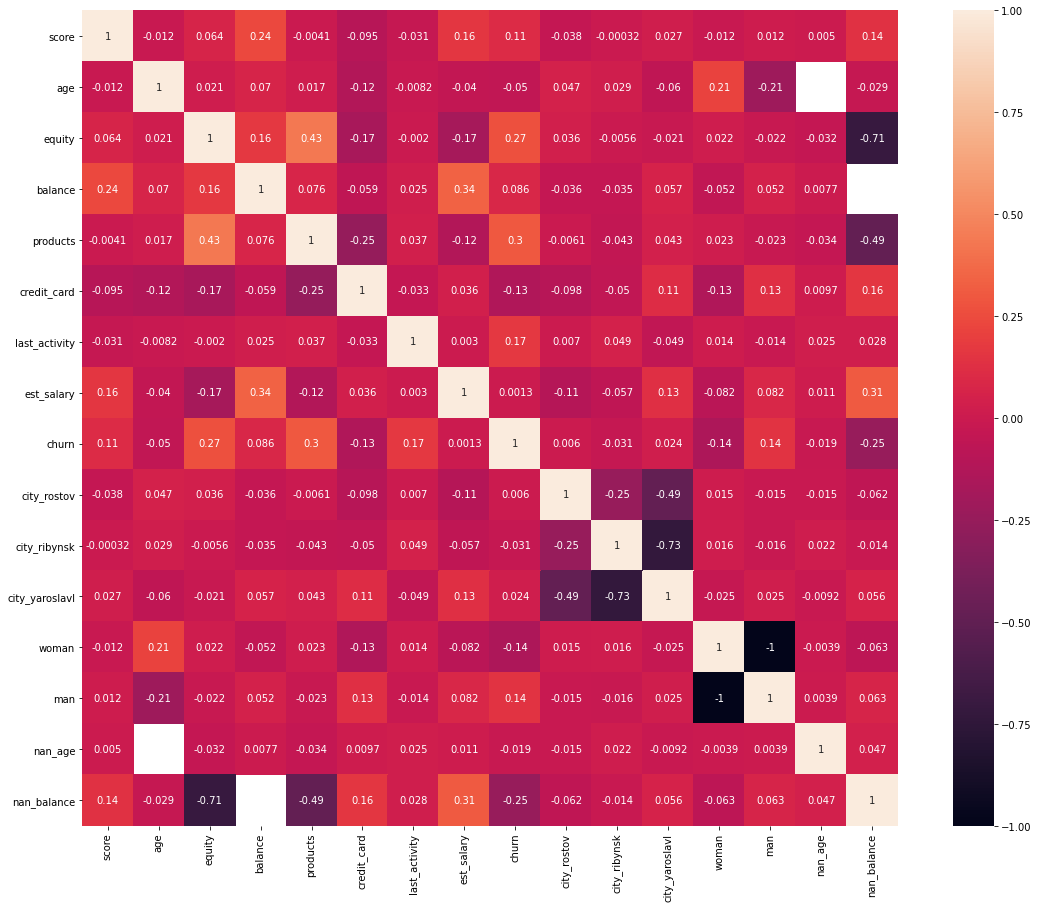

In [9]:
#исключим столбец userid из матрицы корреляций
cm = data.drop('userid', axis=1).corr() 
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cm, annot=True, square=True) 

plt.show()

In [10]:
#определим минимальное значение баланса
data['balance'].min()

0.0

- Пропуск значений в столбце с возрастом совершенно случайны (**MCAR**), т.е. не зависит от других признаков. Закроем их заглушкой - значением "0", т.к. возраст не может быть нулевым. 
- Пропуск значений в столбце с балансом отсутствуют не случайно (**MNAR**), т.к. есть средняя и высокая корреляция с другими признаками, например, с количеством баллов собсвенности (equity), количеством продуктов (products) и оценочного дохода клиента (est_salary). Заполним пустые значения баланса заглушкой "-1", т.к. значение баланса не может быть отрицательным.

Будем учитывать заглушки в дальнейшем анализе.

In [11]:
data['balance'] = data['balance'].fillna(-1)
data['age'] = data['age'].fillna(0)

#уберем ненужные столбцы
data = data.drop(['nan_age', 'nan_balance'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userid          10000 non-null  int64  
 1   score           10000 non-null  float64
 2   city            10000 non-null  object 
 3   gender          10000 non-null  object 
 4   age             10000 non-null  float64
 5   equity          10000 non-null  int64  
 6   balance         10000 non-null  float64
 7   products        10000 non-null  int64  
 8   credit_card     10000 non-null  int64  
 9   last_activity   10000 non-null  int64  
 10  est_salary      10000 non-null  float64
 11  churn           10000 non-null  int64  
 12  city_rostov     10000 non-null  uint8  
 13  city_ribynsk    10000 non-null  uint8  
 14  city_yaroslavl  10000 non-null  uint8  
 15  woman           10000 non-null  uint8  
 16  man             10000 non-null  uint8  
dtypes: float64(4), int64(6), object(

### Преобразование типов данных

Преобразуем тип данных в столбцах score и age на int 

In [12]:
# выведем все значения, которые принимают поля score и age
print(data.score.unique())
print(data.age.unique())

[ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  688.  659.  817.  718.  705.  920.  652.  649.  862.  770.  824.
  934.  952.  977.  840.  709.  878.  808.  900.  7

In [13]:
data['score'] = data['score'].astype(int)
data['age'] = data['age'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userid          10000 non-null  int64  
 1   score           10000 non-null  int64  
 2   city            10000 non-null  object 
 3   gender          10000 non-null  object 
 4   age             10000 non-null  int64  
 5   equity          10000 non-null  int64  
 6   balance         10000 non-null  float64
 7   products        10000 non-null  int64  
 8   credit_card     10000 non-null  int64  
 9   last_activity   10000 non-null  int64  
 10  est_salary      10000 non-null  float64
 11  churn           10000 non-null  int64  
 12  city_rostov     10000 non-null  uint8  
 13  city_ribynsk    10000 non-null  uint8  
 14  city_yaroslavl  10000 non-null  uint8  
 15  woman           10000 non-null  uint8  
 16  man             10000 non-null  uint8  
dtypes: float64(2), int64(8), object(

### Поиск и обработка явных и неявных дубликатов по user_id

#### Найдем явные дубликаты по user_id

Выведем количество явных дубликатов по всем столбцам

In [14]:
data.duplicated().sum()

0

Выведем количество явных дубликатов по userid

In [15]:
data.duplicated(subset='userid').sum()

73

Выведем явные дубликаты по userid

In [16]:
#выделим userid, которые имеют дубликаты, в отдельный список
duplicate_userid = data.loc[data.duplicated(subset='userid') == True]['userid']

#выведем строки, в которых содержатся дублирующие userid
data.loc[data['userid'].isin(duplicate_userid)].sort_values(by='userid').head(10)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_ribynsk,city_yaroslavl,woman,man
1893,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0,1,0,1,0
7694,116540,887,Ярославль,Ж,38,0,-1.00,1,0,1,119247.61,0,0,0,1,1,0
7542,117943,880,Ярославль,Ж,40,0,-1.00,1,1,0,137718.93,0,0,0,1,1,0
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,1,0,1,0
5896,120258,905,Ярославль,М,30,0,-1.00,1,1,1,146427.96,0,0,0,1,0,1
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,1,0,1,0
1411,123461,829,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1,0,0,1,1,0
8638,123461,934,Рыбинск,М,34,0,-1.00,2,1,0,291619.27,0,0,1,0,0,1
8164,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,0,0,1,1,0
9775,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,0,1,0,1,0


In [17]:
#найдем количество явных дубликатов по городу и userid
data.duplicated(subset=['userid', 'city']).sum()

0

Пользователи с одинаковыми значениями userid имеют разный город и возраст. Скорее всего это разные пользователи, а userid уникален только в рамках одного города.

В таком случае одинаковые значения userid не являются дубликатами и не нуждаются в обработке

#### Найдем неявные дубликаты по категориальным столбцам

В датасете представлены категориальные столбцы: city, gender, credit_card, last_activity, churn. Рассмотрим значения, которые они принимают

In [18]:
category_col = ['city', 'gender', 'credit_card', 'last_activity', 'churn']

for col in category_col:
  print('-'* 25)
  print(col, data[col].sort_values().unique())


-------------------------
city ['Ростов' 'Рыбинск' 'Ярославль']
-------------------------
gender ['Ж' 'М']
-------------------------
credit_card [0 1]
-------------------------
last_activity [0 1]
-------------------------
churn [0 1]


Неявных дубликатов нет.

## Исследовательский анализ данных

### Анализ распределения признаков в разрезе оттока

#### Ознакомимся с датасетом

In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.00,171814.71,33708.24,94561.00,142810.25,172728.00,201261.75,229145.00
score,10000.00,848.70,65.45,642.00,802.00,853.00,900.00,1000.00
age,10000.00,42.62,12.36,0.00,33.00,40.00,51.00,86.00
equity,10000.00,2.63,1.98,0.00,0.00,3.00,4.00,9.00
balance,10000.00,637815.28,1773030.22,-1.00,60846.06,375878.86,802742.16,119113552.01
products,10000.00,1.87,0.79,0.00,1.00,2.00,2.00,5.00
credit_card,10000.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
last_activity,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
est_salary,10000.00,147866.89,139388.51,2546.30,75251.90,119658.10,174500.54,1395064.45
churn,10000.00,0.18,0.39,0.00,0.00,0.00,0.00,1.00


- Средний отток состаляет 18%
- Соотношение мужчин и женщин одинаковое. 
- 59% клиентов из Ярославля, 27% из Рыбинска, 14% из Ростова.
- В среднем на балансе счета клиента лежит 640 тыс. руб. При этом максимальная сумма около 120 млн. Присутствую аномальные значения.
- Средний доход клиента около 150 тыс. руб. При этом медиана 120 тыс. руб. 
- 68% клиентов имеют кредитную карту.
- Соотношение активных и неактивных пользователей 52% к 48%.
 

#### Посмотрим соотношение тех, кто ушел и тех, кто остался

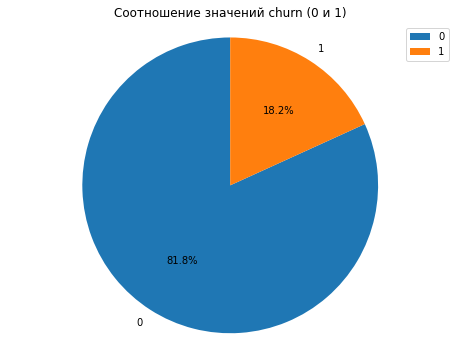

In [20]:
# Подсчет количества 0 и 1 в столбце churn
churn_counts = data['churn'].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Соотношение значений churn (0 и 1)')
plt.axis('equal')  # Чтобы диаграмма была круглой
plt.legend()
plt.show()

#### Посмотрим на средние значения признаков среди тех, кто ушел и тех, кто остался

In [21]:
data_pivot = data.groupby('churn').mean()
data_pivot

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,city_rostov,city_ribynsk,city_yaroslavl,woman,man
churn,,,,,,,,,,,,,,
0,172004.36,845.43,42.89,2.37,529220.91,1.76,0.71,0.48,147783.20,0.14,0.28,0.58,0.53,0.47
1,170962.35,863.40,41.43,3.76,1125893.31,2.38,0.55,0.70,148243.01,0.15,0.24,0.61,0.35,0.65


Пользователи, которые перестают пользоваться услугами банка:
- имеют большее кол-во баллов собственности
- имеют больше денег на балансе
- пользуются большим количеством продуктов банка
- реже пользуются кредитными картами
- чаще являются активными пользователями
- чаще являются мужчинами

#### Проанализируем категориальные и дискретные признаки

Построим столбчатые диаграммы для категориальных и дискретных признаков по кол-ву пользователей в разрезе оттока

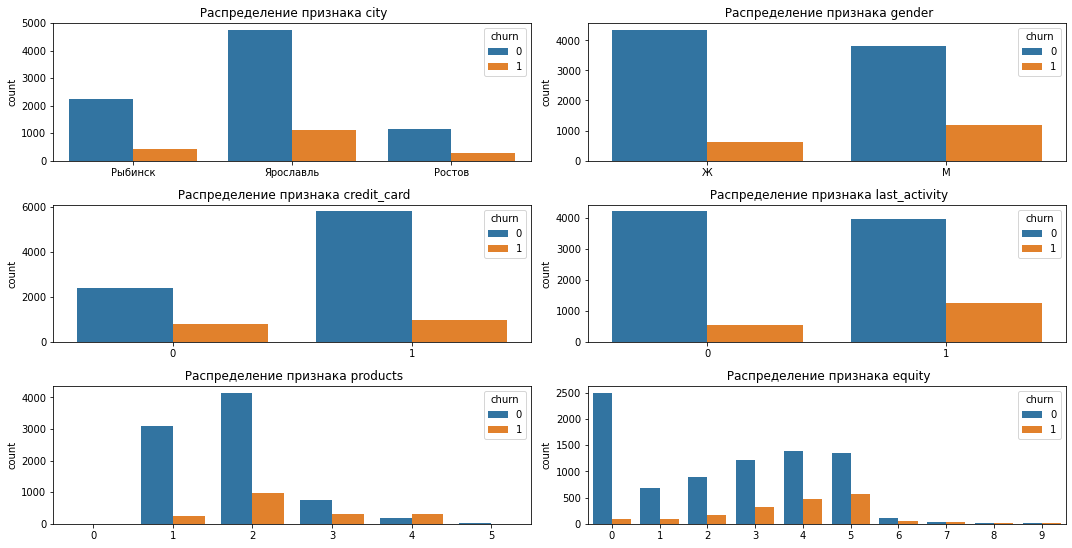

In [22]:
category_columns = ['city', 'gender', 'credit_card', 'last_activity', 'products', 'equity']

# Рассчитываем количество строк для сетки
number_row = int(len(category_columns) / 2)

# Создаем сетку графиков
fig, ax = plt.subplots(nrows=number_row + 1, ncols=2, figsize=(15, 10))

# Вытягиваем оси
ax = ax.flatten()

# Задаём цикл для построения графиков
for i in range(len(category_columns)):
    sns.countplot(data=data, x=category_columns[i], hue='churn', ax=ax[i])
    ax[i].set_title(f' Распределение признака {category_columns[i]}')
    ax[i].set_xlabel('')


# Удаляем лишние оси
if len(category_columns) % 2 != 0:
    for j in range(2 - (len(category_columns) % 2)):
        fig.delaxes(ax[-1-j])
else:
    fig.delaxes(ax[-1])
    fig.delaxes(ax[-2])

# Чтобы все надписи влезли
fig.tight_layout()
fig.show()

In [23]:
data[data['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_ribynsk,city_yaroslavl,woman,man
8957,147837,962,Рыбинск,Ж,79,3,-1.00,0,0,0,25063.96,1,0,1,0,1,0


В датасете присутствует пользователь с нулевым количеством продуктов, что является аномалией, т.к. любой клиент банка должен иметь хотя бы один продукт. Исключим его из датасета

In [24]:
data = data.query('products != 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userid          9999 non-null   int64  
 1   score           9999 non-null   int64  
 2   city            9999 non-null   object 
 3   gender          9999 non-null   object 
 4   age             9999 non-null   int64  
 5   equity          9999 non-null   int64  
 6   balance         9999 non-null   float64
 7   products        9999 non-null   int64  
 8   credit_card     9999 non-null   int64  
 9   last_activity   9999 non-null   int64  
 10  est_salary      9999 non-null   float64
 11  churn           9999 non-null   int64  
 12  city_rostov     9999 non-null   uint8  
 13  city_ribynsk    9999 non-null   uint8  
 14  city_yaroslavl  9999 non-null   uint8  
 15  woman           9999 non-null   uint8  
 16  man             9999 non-null   uint8  
dtypes: float64(2), int64(8), object(2

Построим столбчатые диаграммы для категориальных переменных по среднему значению оттока

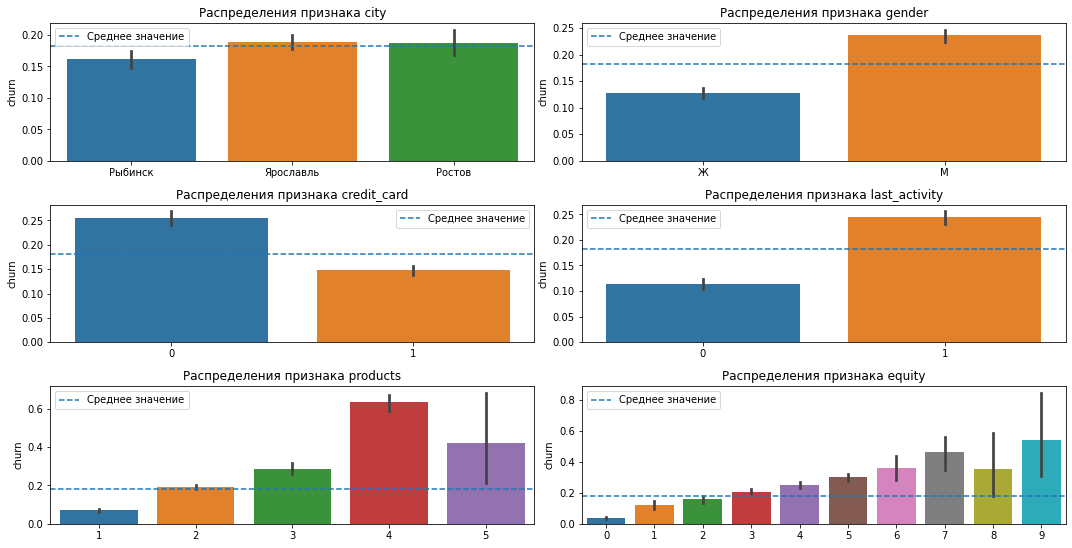

In [25]:
# Создаем сетку графиков
fig, ax = plt.subplots(nrows=number_row + 1, ncols=2, figsize=(15, 10))

# Вытягиваем оси
ax = ax.flatten()

for i in range(len(category_columns)):
    sns.barplot(y=data['churn'], x=data[category_columns[i]], ax=ax[i]) 
    ax[i].set_title(f'Распределения признака {category_columns[i]}')
    ax[i].set_xlabel('')  
    ax[i].axhline(y=data['churn'].mean(), linestyle='--', label='Среднее значение') 
    ax[i].legend()
    
if len(category_columns) % 2 != 0:
    for j in range(2 - (len(category_columns) % 2)):
        fig.delaxes(ax[-1-j])
else:
    fig.delaxes(ax[-1])
    fig.delaxes(ax[-2])    

   
fig.tight_layout()
fig.show()    

- Большая часть пользователей из Ярославля, меньшая часть из Ростова. Отток клиентов меньше у пользователей из Рыбинска (16%).
- Мужчины чаще прекращают взаимодействие с банком, чем женщины (около 24% и 13% соответственно) 
- Пользователи без кредитных карт чаще перестают пользоваться банком (отток 25% без кредитной карты, 15% с кредитной картой)
- Активные пользователи чаще прекращают взаимодействовать с банком (25% активных пользователей против 12% неактивных). Распределение таких клиентов одинаковое
- Пользователи использующие 3 продукта и больше всего подвержены оттоку (от 30% до 55%), а использующие 1 продукт меньше всего (около 8%)
- Пользователи с баллом собственности больше 3 включительно имеют большую долю оттока, чем в среднее значение 18%. Чем выше балл собственности, тем выше доля оттока.

#### Проанализируем непрерыные признаки

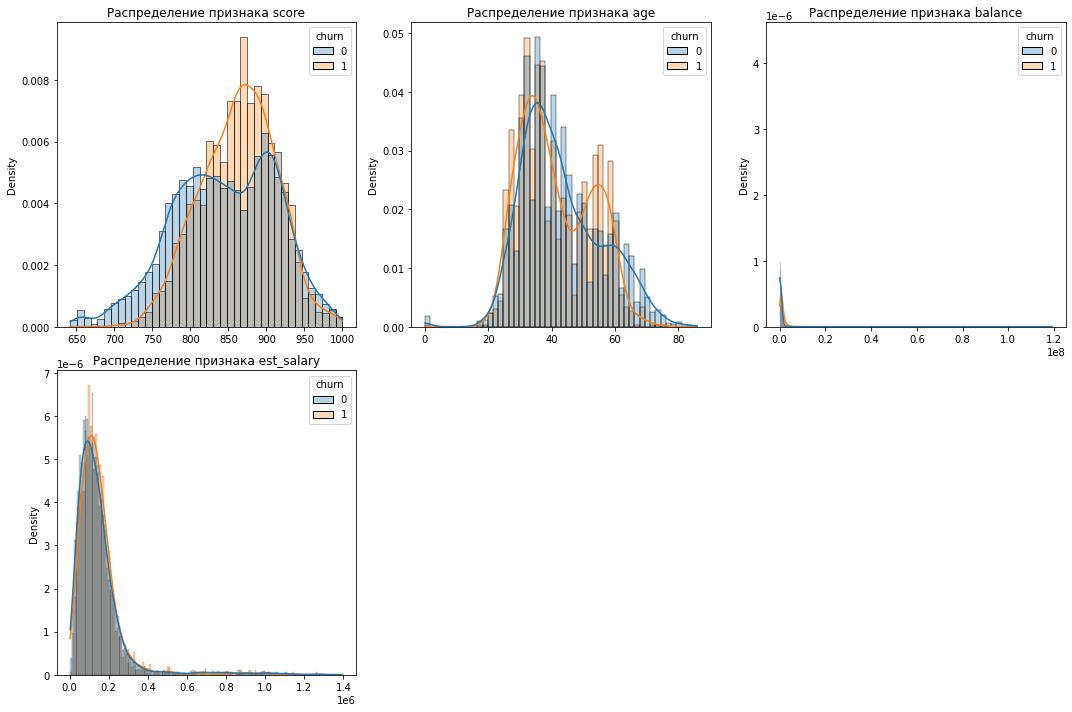

In [26]:
quantitative_columns = ['score', 'age', 'balance',  'est_salary']

number_row = int(len(quantitative_columns)/3)
# добавим figsize=(15, 15) чтобы не было слишком мелкие графики
fig, ax = plt.subplots(nrows = number_row + 1, ncols=3, figsize=(15, 10))


# вытягиваем
ax = ax.flatten()

for i in range(len(quantitative_columns)):
    sns.histplot(data = data, x = data[quantitative_columns[i]], hue='churn', ax=ax[i], 
                 kde = True, stat='density', common_norm=False, alpha=0.3)
    
    ax[i].set_title(f'Распределение признака {quantitative_columns[i]}')
    ax[i].set_xlabel('')

if len(quantitative_columns) % 3 != 0:
    for j in range(2 - (len(category_columns) % 3)):
        fig.delaxes(ax[-1-j])
else:
    fig.delaxes(ax[-1])
    fig.delaxes(ax[-2]) 
    fig.delaxes(ax[-3]) 
    
# чтобы все надписи влезли    
fig.tight_layout()
fig.show()    

##### Определим выбросы в столбце balance

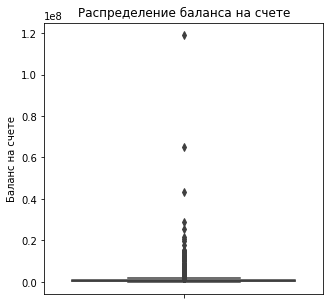

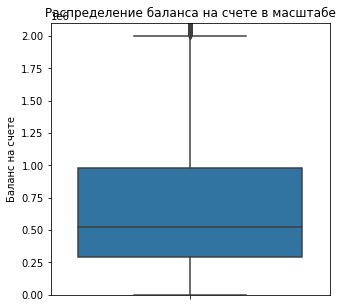

In [27]:
# учтем загрушку поставленную ранее
plt.figure(figsize=(5, 5))
sns.boxplot(data=data[data['balance'] >= 0], y='balance')
plt.title('Распределение баланса на счете')
plt.ylabel('Баланс на счете')
plt.show()

# увеличим масштаб
plt.figure(figsize=(5, 5))
sns.boxplot(data=data[data['balance'] >= 0], y='balance')
plt.title('Распределение баланса на счете в масштабе')
plt.ylabel('Баланс на счете')
plt.ylim(0, 2100000)
plt.show()


Выброс начинается с 2 млн. Добавим новый столбец для идентификации выброса в поле balance, добавим туда строки с заглушкой

In [28]:
def determine_ejection(row, col, x):
    if row[col] >= x or row[col] < 0:
        return 1
    else:
        return 0

data['balance_ejection'] = data.apply(lambda row: determine_ejection(row, 'balance', 2000000), axis=1)

data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_ribynsk,city_yaroslavl,woman,man,balance_ejection
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,0
2,120722,892,Рыбинск,Ж,30,0,-1.00,1,1,1,107683.34,0,0,1,0,1,0,1
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,0


##### Определим выбросы в столбце est_salary

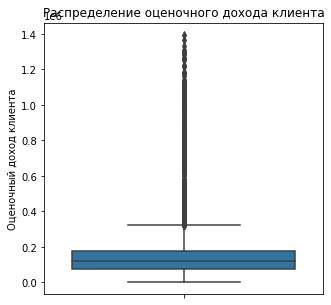

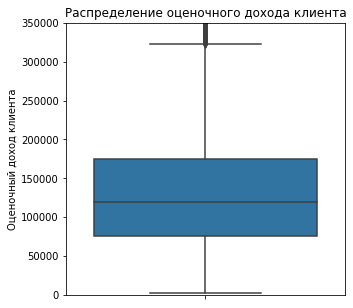

In [29]:
# учтем загрушку поставленную ранее
plt.figure(figsize=(5, 5))
sns.boxplot(data=data, y='est_salary')
plt.title('Распределение оценочного дохода клиента')
plt.ylabel('Оценочный доход клиента')
plt.show()

# увеличим масштаб
plt.figure(figsize=(5, 5))
sns.boxplot(data=data[data['est_salary'] >= 0], y='est_salary')
plt.title('Распределение оценочного дохода клиента')
plt.ylabel('Оценочный доход клиента')
plt.ylim(0, 350000)
plt.show()


Выброс начинается с 325 000. Добавим новый столбец для идентификации выброса в поле est_salary.

In [30]:
data['est_salary_ejection'] = data.apply(lambda row: determine_ejection(row, 'est_salary', 325000), axis=1)

data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_ribynsk,city_yaroslavl,woman,man,balance_ejection,est_salary_ejection
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,0,0
2,120722,892,Рыбинск,Ж,30,0,-1.00,1,1,1,107683.34,0,0,1,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,0,0


##### Проанализируем признаки balance и est_salary без выбросов

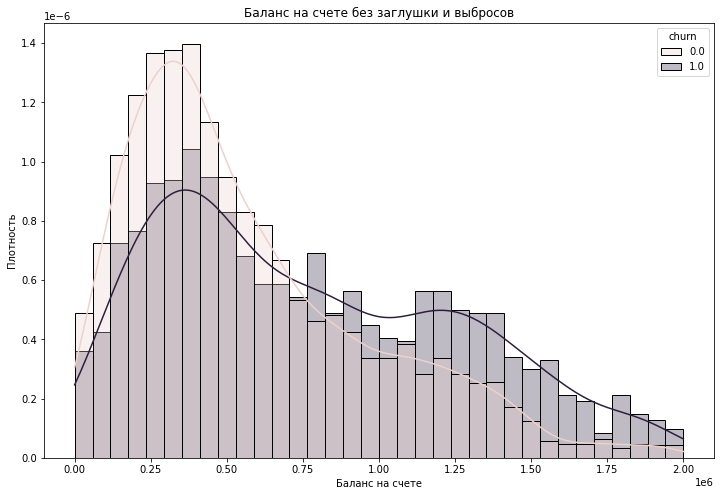

In [31]:
plt.figure(figsize=(12, 8))

sns.histplot(data = data[data['balance_ejection'] == 0], x = data['balance'], hue='churn', 
             kde = True, stat="density", common_norm=False, alpha=0.3)

plt.title('Баланс на счете без заглушки и выбросов')
plt.ylabel('Плотность')
plt.xlabel('Баланс на счете')
plt.show()

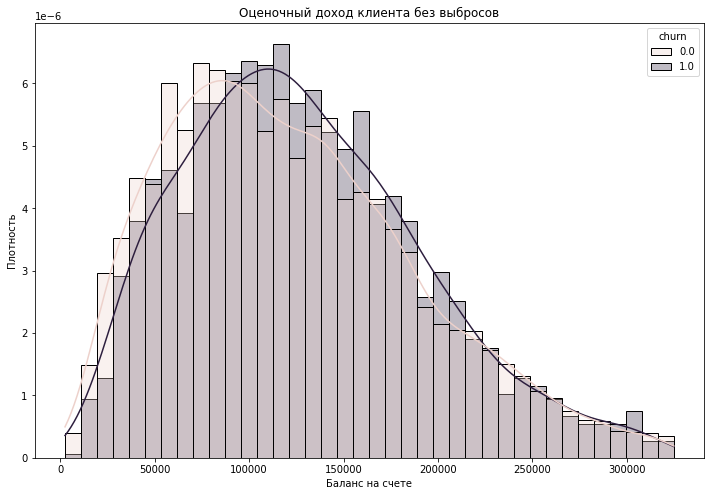

In [32]:
plt.figure(figsize=(12, 8))

sns.histplot(data = data[data['est_salary_ejection'] == 0], x = data['est_salary'], hue='churn', 
             kde = True, stat="density", common_norm=False, alpha=0.3)

plt.title('Оценочный доход клиента без выбросов')
plt.ylabel('Плотность')
plt.xlabel('Баланс на счете')
plt.show()

- Плотность непрерывных признаков лояльных и "отвалившихся" клиентов имеют схожие тенденции. 
- Пик распределения баллов кредитного скоринга для лояльных клиентов 900, а для отвалившихся 875
- Пик лояльных пользователей наблюдается в районе 38 лет, а для отвалившихся в районе 35 лет и малый пик в районе 55 лет.
- Пик по оценочному доходу для лояльных находится на уровне 90 000, а отвалившихся клиентов на 110 000. 
- Пик баланса на счете совпадает для обеих категорий и находится в районе 400 000
- Оценочный доход клиента и баланс на счете имеют выбросы на уровне 325 000 и 2 000 000 соответственно

- Распределение баллов кредитного скоринга, возраста, оценочного дохода клиента и баланс на счете близко к нормальному распределению.

#### Промежуточный вывод

Общий вывод:
- Средний отток составляет 18%
- При одинаковом соотношении мужчины чаще прекращают работать с банком (24%), чем женщины (13%)
- При близком соотношении активные пользователи чаще прекращают работать с банком (25%), чем неактивные (12%)
- Наличие кредитной карты влияет на отток (25% без карты, 13% с картой)
- Пользователи использующие 3 продукта и больше всего подвержены оттоку (от 30% до 65%), а использующие 1 продукт меньше всего (около 8%)
- Наибольшая часть клиентов из Ярославля. Клиенты из Рыбинска менее подвержены оттоку (16%)
- Балл собственности более 3 повышает отток (от 20% до 55%)
- Средний возраст отвалившихся клиентов наблюдается в районе от 30 до 40 лет и от 50 до 60 лет
- Выбросы по балансу на счете наблюдаются от 2 млн, а по оценочному доходу от 325 тыс.

### Анализ портретов клиентов в разрезе оттока

Раздели признаки по типу:
- Непрерывные переменные: score, age, balance, est_salary - найдем среднее значение и дополнительно медиану признаков с выбросами
- Дискретные переменные: equity, products, credit_card, last_activity - найдем медиану
- Незакодированные категориальные переменные: city, gender - найдем моду

In [33]:
quantitative_columns # определена выше
discrete_columns = ['credit_card', 'last_activity', 'products', 'equity']
uncoded_cat_columns = ['city', 'gender']

data_pivot = data.groupby('churn').agg(
    Средний_балл_кредитного_скоринга=('score','mean'),
    Средний_возраст=('age','mean'),    
    Средний_баланс_на_счете=('balance','mean'),    
    Медианный_баланс_на_счете=('balance','median'), 
    Средний_оценочный_доход_клиента=('est_salary','mean'),    
    Медианный_оценочный_доход_клиента=('est_salary','median'),     
    Медианное_количество_баллов_собственности=('equity','median'),
    Медианное_количество_продуктов=('products','median'),
    Наличие_кредитной_карты=('credit_card','median'),
    Активный_клиент=('last_activity','median'),   
    Мода_по_городу=('city', lambda x: x.mode()),
    Мода_по_полу=('gender', lambda x: x.mode())
).T

data_pivot = data_pivot.rename(columns={0: 'Не отток', 1: 'Отток'})

# Создаем новый столбец для относительной разницы
data_pivot['Относительная_разница'] = None

# Рассчитываем относительную разницу для первых 6 строк
for i in range(6):
    data_pivot['Относительная_разница'][i] = (data_pivot['Отток'][i] - data_pivot['Не отток'][i]) / data_pivot['Отток'][i] * 100   
    
data_pivot

churn,Не отток,Отток,Относительная_разница
Средний_балл_кредитного_скоринга,845.43,863.35,2.08
Средний_возраст,42.89,41.41,-3.58
Средний_баланс_на_счете,529220.91,1126512.28,53.02
Медианный_баланс_на_счете,320687.93,775365.19,58.64
Средний_оценочный_доход_клиента,147783.20,148310.73,0.36
Медианный_оценочный_доход_клиента,118257.71,125395.22,5.69
Медианное_количество_баллов_собственности,3,4,None
Медианное_количество_продуктов,2,2,None
Наличие_кредитной_карты,1,1,None
Активный_клиент,0,1,None


По усредненным данным можно заключить, что:

- "Отвалившиеся" клиенты имеют в 2 раза больший баланс на счете и большее количество баллов собственности, а так же являются активными клиентами по сравнению с лояльными клиентов
- Баллы кредитного скоринга, возраст и оценочный доход клиента в среднем практически не отличается у лояльных и "отвалившихся" клиентов
- "отвалившиеся" клиенты в основном являются мужчинами, а лояльные - женщинами.

Таким образом портрет "отвалившегося" клиента выглядит так:

Мужчина из Ярославля возрастом 41 год с доходом 125 000 руб имеет баланс на счете в банке около 775 000 руб. Пользуется двумя продуктами банка, в том числе кредитной картой, является активным клиентом и имеет 4 балла собственности и 863 балла кредитного скоринга.

Портрет лояльного клиента выглядит так:

Женщина из Ярославля возрастом 43 года с доходом 118 000 руб имеет баланс на счете в банке около 320 000 руб. Пользуется двумя продуктами банка, в том числе кредитной картой, не является активным клиентом и имеет 3 балла собственности и 845 баллов кредитного скоринга.

### Корреляционный анализ признака churn с другими признаками

#### Построим матрицу корреляций (линейная зависимость)

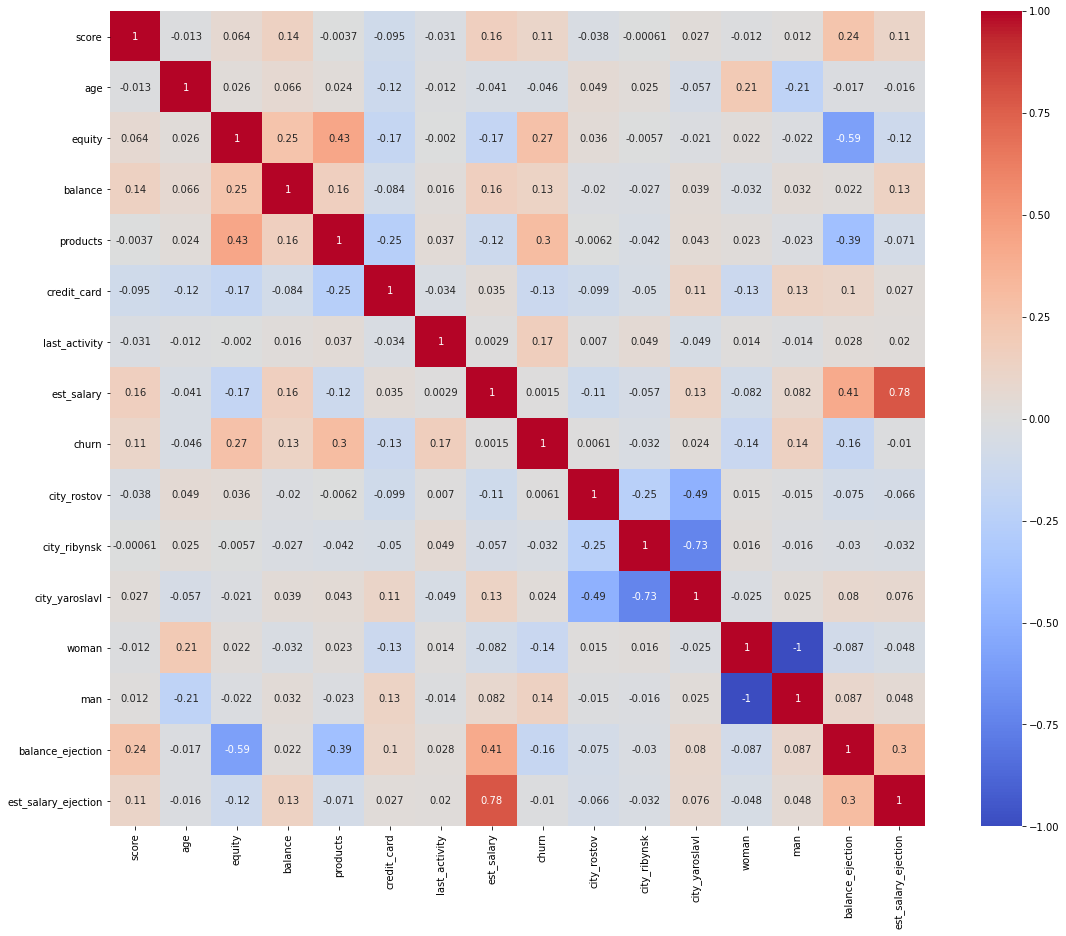

In [34]:
#исключим столбец userid из матрицы корреляций
cm = data.drop('userid', axis=1).corr() 

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', center=0) 

plt.show()

Визуализируем линейную корреляцию оттока с остальными признаками отдельно.

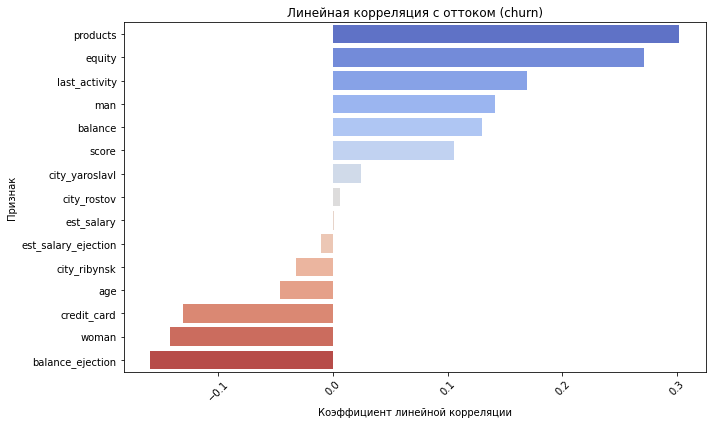

In [35]:
cm_churn = cm['churn'].sort_values(ascending=False)
cm_churn = cm_churn.drop('churn')

plt.figure(figsize=(10, 6))
sns.barplot(x=cm_churn, y=cm_churn.index, palette='coolwarm')
plt.title('Линейная корреляция с оттоком (churn)')
plt.ylabel('Признак')
plt.xlabel('Коэффициент линейной корреляции')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Отток пользователей имеет:
- умеренную корреляцию с количеством продуктов, которые использует пользователей (0,3)
- слабую корреляцию с баллами собственности (0,27), балансом на счете (0,13) и активностью пользователя (0,17). 
- слабую обратную корреляцию с наличием кредитной карты (-0,13)
- слабую корреляцию с полом клиента. Мужчины чаще подвержены оттоку (0,14) , чем женщины (-0,14)

Так же наблюдается:
- умеренная корреляция между количеством продуктов и баллами собственности (0,43)
- слабая обратная корреляция между наличием кредитных карт и количеством продуктов (-0,25)


#### Построим матрицу корреляции (нелинейная зависимость)

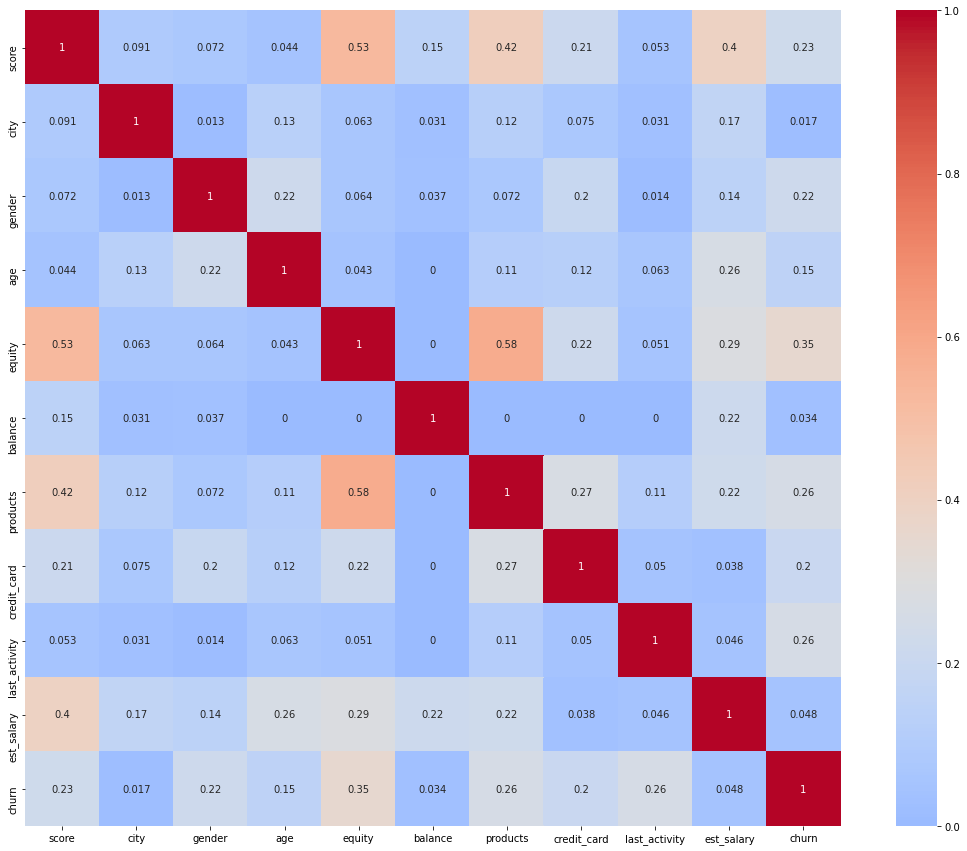

In [36]:
#исключим столбец userid и закодированные столбцы из матрицы нелинейных корреляций

cmn = data.drop(['userid', 'city_rostov', 'city_ribynsk', 'city_yaroslavl', 
                 'woman', 'man', 'balance_ejection', 'est_salary_ejection'], 
                axis=1).phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary']) 

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cmn, annot=True, square=True, cmap='coolwarm', center=0.3) 

plt.show()

Визуализируем нелинейную корреляцию оттока с остальными признаками отдельно.

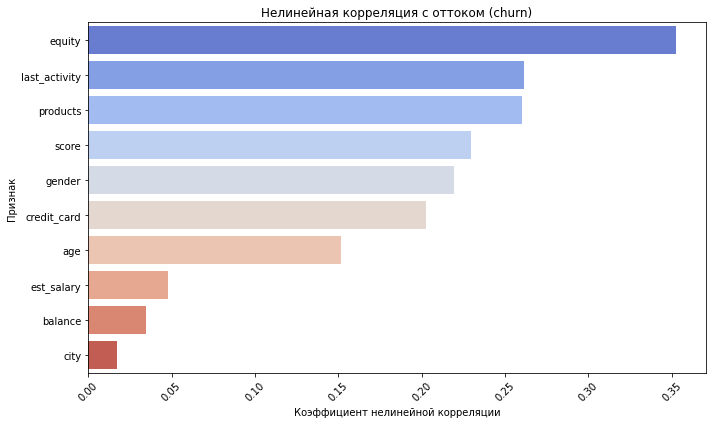

In [37]:
cmn_churn = cmn['churn'].sort_values(ascending=False)
cmn_churn = cmn_churn.drop('churn')

plt.figure(figsize=(10, 6))
sns.barplot(x=cmn_churn, y=cmn_churn.index, palette='coolwarm')
plt.title('Нелинейная корреляция с оттоком (churn)')
plt.ylabel('Признак')
plt.xlabel('Коэффициент нелинейной корреляции')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Отток пользователей имеет:
- умеренную корреляцию с баллами собственности (0,35)
- слабую корреляцию со всеми остальными признаками кроме оценочного дохода клиента и города

Так же наблюдается:
- заметная корреляция между баллами кредитного скоринга и баллами собственности (0,53)
- заметная корреляция между количеством продуктов и баллами собственности (0,58)
- умеренная корреляция между оценочным доходом и баллами кредитного скоринга (0,4)
- умеренная корреляция между количеством продуктов и баллами кредитного скоринга (0,42)

#### Промежуточный вывод

На основании линейной и нелинейно матриц коррелиции следует обратить внимание, что отток клиентов в первую очередь коррелирует с количеством продуктов (0,3) и баллов собственности (0,27), и во вторую очередь с балансом на счете (0,13), активностью пользователя (-0,13) и полом (0,14).
В дополнение нужно обратить внимание на корреляцию между количеством продуктов с баллами собственности (0,43) и с наличием кредитных карт (-0,25), а так же на корреляцию между баллами кредитного скоринга с баллами собственности (0,53) и оценочным доходом пользователя (0,4)

### Вывод по разделу

1. Отток клиентов:

- Средний отток составляет 18%.
- Использование 3 и более продуктов увеличивает отток (от 30% до 65%), в то время как использование 1 продукта снижает отток (около 8%).
- Балл собственности более 3 также повышает отток (от 20% до 55%).
- Активные пользователи имеют более высокий отток (25%) по сравнению с неактивными (12%).
- Отток клиентов без кредитной карты (25%) выше, чем с картой (13%).
- Мужчины чаще прекращают работать с банком (24%) по сравнению с женщинами (13%).
- Клиенты из Ярославля составляют наибольшую часть оттока, в то время как клиенты из Рыбинска менее подвержены (16%).
- Средний возраст отвалившихся клиентов составляет 30-40 и 50-60 лет.
- Выбросы по балансу на счете наблюдаются от 2 млн, по оценочному доходу — от 325 тыс

2. Портреты клиентов:

**"Отвалившийся" клиент:** Мужчина, 41 год, из Ярославля, с доходом 125 000 руб, баланс на счете около 775 000 руб, пользуется двумя продуктами, включая кредитную карту, активный, 4 балла собственности, 863 балла кредитного скоринга.

**Лояльный клиент:** Женщина, 43 года, из Ярославля, с доходом 118 000 руб, баланс на счете около 320 000 руб, пользуется двумя продуктами, включая кредитную карту, не активный, 3 балла собственности, 845 баллов кредитного скоринга.

3. Корреляции:

- Отток клиентов коррелирует в первую очередь с количеством продуктов (0,3) и баллами собственности (0,27).
- Во вторую очередь с балансом на счете (0,13), активностью пользователя (-0,13) и полом (0,14).
- Сильная корреляция между количеством продуктов и баллами собственности (0,43) и наличием кредитных карт (-0,25).
- Корреляция между баллами кредитного скоринга и баллами собственности (0,53) и оценочным доходом пользователя (0,4).

## Проверка статистических гипотез

### Гипотеза о средних оценочных доходах клиента тех, кто ушел и тех, кто остался, среди мужчин

#### Проверим распределение оценочного дохода клиентов тех, кто ушел и тех, кто остался среди мужчин

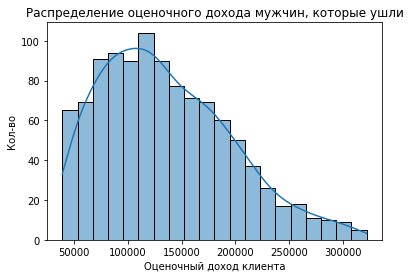

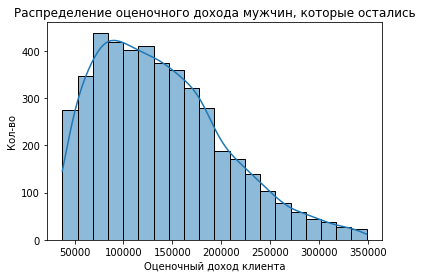

In [38]:
#отберем нужные данные
data_men_churn = data.query('man == 1 and churn >= 1')['est_salary']
data_men_no_churn = data.query('man == 1 and churn >= 0')['est_salary']

#исключим выбросы из обоих датасетов на границах 5% и 95%
data_men_churn = data_men_churn.loc[(data_men_churn >= np.percentile(data_men_churn, 5))
                                          & (data_men_churn <= np.percentile(data_men_churn, 95))]

data_men_no_churn = data_men_no_churn.loc[(data_men_no_churn >= np.percentile(data_men_no_churn, 5))
                                          & (data_men_no_churn <= np.percentile(data_men_no_churn, 95))]

# построим графики распределения
sns.histplot(x = data_men_churn, kde=True, bins=20)
plt.title('Распределение оценочного дохода мужчин, которые ушли')
plt.xlabel('Оценочный доход клиента')
plt.ylabel('Кол-во')
plt.show()

sns.histplot(x = data_men_no_churn, kde=True, bins=20)
plt.title('Распределение оценочного дохода мужчин, которые остались')
plt.xlabel('Оценочный доход клиента')
plt.ylabel('Кол-во')
plt.show()

<AxesSubplot:xlabel='churn', ylabel='est_salary'>

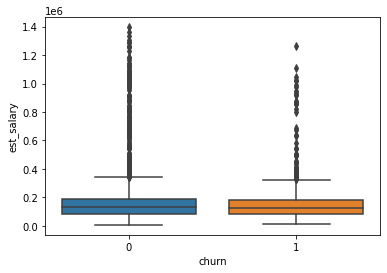

In [39]:
# код ревьюера
#sns.boxplot(data=data.query('man == 1'),x='churn', y='est_salary')

- Выборки независимые
- Дисперсии равны
- Распределение нормальное в обоих случаях.
- Явные выбросы отсутствуют

На основании этого можем использовать стандартный t-тест Стьюдента

#### Сформулируем гипотезы

Нулевая гипотеза: оценочный доход мужчин, которые ушли и которые остались, равны

Альтернативная гипотеза: оценочный доход мужчин, которые ушли и которые остались, не равны

In [40]:
results_1 = st.ttest_ind(data_men_churn, data_men_no_churn, alternative='two-sided')

alpha = 0.05 # уровень статистической значимости
print('p-значение:', results_1.pvalue)

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.18000945085889777
Не получилось отвергнуть нулевую гипотезу


Мы не можем отвергнуть нулевую гипотезу. P-значение составило около 18%, что больше уровня статистической значимости. Можем утверждать, что скорее всего средний оценочный доход мужчин, которые ушли и которые остались, одинаковый.

### Гипотеза о среднем балансе на счет тех, кто ушел и тех среди клиентов моложе 45 лет

#### Проверим распределение баланса на счете тех, кто ушел и тех, кто среди клиентов моложе 45 лет

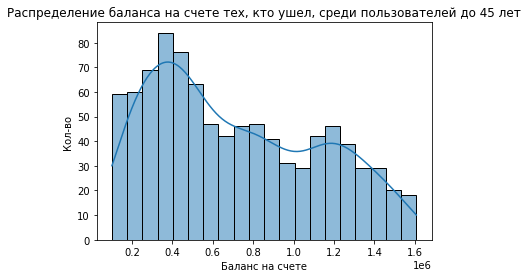

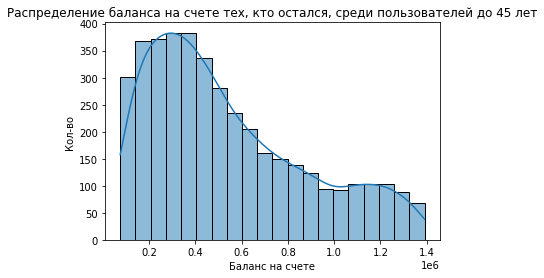

In [41]:
# учтем загрушку поставленную ранее 
data_balance_churn = data.query('age < 45 and churn >= 1 and balance >= 0 and balance_ejection == 0')['balance']
data_balance_no_churn = data.query('age < 45 and churn >= 0 and balance >= 0 and balance_ejection == 0')['balance']

#исключим выбросы из обоих датасетов на границах 5% и 95%
data_balance_churn = data_balance_churn.loc[(data_balance_churn >= np.percentile(data_balance_churn, 5))
                                          & (data_balance_churn <= np.percentile(data_balance_churn, 95))]

data_balance_no_churn = data_balance_no_churn.loc[(data_balance_no_churn >= np.percentile(data_balance_no_churn, 5))
                                          & (data_balance_no_churn <= np.percentile(data_balance_no_churn, 95))]


sns.histplot(x = data_balance_churn, kde=True, bins=20)
plt.title('Распределение баланса на счете тех, кто ушел, среди пользователей до 45 лет')
plt.xlabel('Баланс на счете')
plt.ylabel('Кол-во')
plt.show()

sns.histplot(x = data_balance_no_churn, kde=True, bins=20)
plt.title('Распределение баланса на счете тех, кто остался, среди пользователей до 45 лет')
plt.xlabel('Баланс на счете')
plt.ylabel('Кол-во')
plt.show()

Распределение нормальное в обоих случаях.

#### Сформулируем гипотезы

Нулевая гипотеза: Среди клиентов моложе 45 лет балансы на счетах тех, кто ушел и тех, кто остался, равны

Альтернативная гипотеза: Среди клиентов моложе 45 лет балансы на счетах тех, кто ушел больше баланса на счетах тех, кто остался.

In [42]:
results_1 = st.ttest_ind(data_balance_churn, data_balance_no_churn, alternative='greater')

alpha = 0.05 # уровень статистической значимости
print('p-значение:', results_1.pvalue)

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.678724635321094e-40
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. P-значение составило менее 1%, что меньше уровня статистической значимости. Можем утверждать, что среди клиентов моложе 45 лет баланс на счете "отвалившихся" клиентов больше, чем баланс на счете лояльных клиентов

## Подведение промежуточных итогов

На основании предыдущих выводов, выделим признаки на основании, которых будет проводить сегментацию:
1. Количество используемых продуктов: более 3-х включительно и менее 2-х включительно
2. Количество баллов собственности: более 4-х включительно и менее 3-х включительно
3. Активность клиента
4. Наличие кредитной карты
5. Гендер
6. Возраст: 50-60 лет и остальные
7. Баланс на счете: более 2 млн и менее 2 млн
8. Оценочный доход клиента: более 325 тыс. и менее 325 тыс. 

При распределении сегментов следует учитывать корреляции:
- Отток клиентов коррелирует в первую очередь с количеством продуктов (0,3) и баллами собственности (0,27).
- Во вторую очередь с балансом на счете (0,13), активностью пользователя (-0,13) и полом (0,14).
- Умеренная корреляция между количеством продуктов и баллами собственности (0,43) и наличием кредитных карт (-0,25).
- Корреляция между баллами кредитного скоринга и баллами собственности (0,53) и оценочным доходом пользователя (0,4).

## Сегментация и приоритезация

### Сформулируем сегменты

Разделим клиентов на следующие сегменты:
1. A - Клиенты использующие более 3-х продуктов (включительно) и имеющие более 4-х баллов собственности (включительно). 

В сегмент "А" добавляем признаки с самой высокой корреляцией с оттоком, т.е. кол-во продуктов и кол-во баллов собственноcти. Так же между эти признаками наблюдается умеренная корреляция, т.е. сегмент будет консистентным.

2. B - Активные клиенты без кредитных карт

В сегмент "B" добавляем признаки характеризующие взаимодействие клиента с банком, а именно активности и наличие кредитной карты.

3. C - Мужчины 50-60 лет 

В сегмент "C" добавляем неизменяемые признаки характеризующие клиента, т.е. пол и возраст. Ограничение возраста 50-60 лет связано с образованием локального пика у "отвалившихся" клиентов на гистограммев п.4.1.4., который не наблюдается у лояльных клиентов. 
    
4. D - Баланс на счете: более 2 млн и оценочный доход более 325 тыс.

В сегмент "D" добавляем клиентов с аномальной суммой денег (баланс на счете и оценочный доход клиента). Банк особенно заинтересован привлекать наиболее платежеспособных клиентов. 

5. O (other) - остальные клиенты не попавшие ни в один сегмент

Один клиент может принадлежать сразу нескольким сегментам. В противном случае он включается в сегмент "O".

In [43]:
#Создадим функцию для добавления колонки с сегментом
def segmentation(df, col, rule):
    df[col] = df.eval(rule).astype(int)
    return df

#добавим сегметт А
data_final = segmentation(data, 'A', 'products >= 3 and equity >= 4')

#добавим сегметт B
data_final = segmentation(data_final, 'B', 'last_activity == 1 and credit_card == 0')

#добавим сегметт C
data_final = segmentation(data_final, 'C', '(age >= 50 and age <= 60) and man == 1')

#добавим сегметт D
data_final = segmentation(data_final, 'D', 'balance >= 2000000 or est_salary >= 325000')

#добавим сегметт O (other)
data_final = segmentation(data_final, 'O', 'A + B + C + D == 0')

data_final.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,...,city_yaroslavl,woman,man,balance_ejection,est_salary_ejection,A,B,C,D,O
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,...,0,1,0,0,0,0,1,0,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,...,0,1,0,0,0,1,0,0,0,0
2,120722,892,Рыбинск,Ж,30,0,-1.00,1,1,1,...,0,1,0,1,0,0,0,0,0,1
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,...,1,1,0,0,0,0,1,0,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,...,1,0,1,0,0,0,0,0,0,1


Сведем данные о сегментах

In [44]:
seg_col = ['segment', 'rel_churn', 'users', 'churn_users']

segmentation_data = pd.DataFrame(columns=seg_col)

segments = ['A', 'B', 'C', 'D', 'O']
for i, seg in enumerate(segments):
    segmentation_data.loc[i, 'segment'] = seg
    segmentation_data.loc[i, 'rel_churn'] = data[data[seg] == 1]['churn'].mean()
    segmentation_data.loc[i, 'users'] = data[data[seg] == 1]['churn'].count()
    segmentation_data.loc[i, 'churn_users'] = data[(data[seg] == 1) & (data['churn'] == 1)]['churn'].count()

#Добавим столбец с кол-вом лояльных клиентов
segmentation_data['loyal_users'] = segmentation_data['users'] - segmentation_data['churn_users']    
    
segmentation_data    

,segment,rel_churn,users,churn_users,loyal_users
0,A,0.45,953,426,527
1,B,0.35,1751,613,1138
2,C,0.33,777,259,518
3,D,0.30,785,236,549
4,O,0.11,6547,713,5834


### Проведем приоритезацию

Поскольку целью проекта является удержание лояльных клиентов в условиях ограниченности ресурсов отдела маркетинга, то приоритезацию проведем на основании кол-ва лояльных клиентов и % оттока в сегменте. 

Сегменты с более высоким % оттока имеют больший риск потери клиента, при этом сегменты с меньшим количеством лояльных клиентов потребует меньших ресурсов от отдела маркетинга. Поэтому наиболее приоритетный сегмент будем определять на основании отношения rel_churn к loyal_users (priority_value). 

In [45]:
#Добавим столбец со значением приоритета, умножим его на 1000 для удоства отображения

segmentation_data['priority_value'] = segmentation_data['rel_churn'] / segmentation_data['loyal_users'] * 1000 

segmentation_data = segmentation_data.sort_values(by='priority_value', ascending=False)

segmentation_data

,segment,rel_churn,users,churn_users,loyal_users,priority_value
0,A,0.45,953,426,527,0.85
2,C,0.33,777,259,518,0.64
3,D,0.30,785,236,549,0.55
1,B,0.35,1751,613,1138,0.31
4,O,0.11,6547,713,5834,0.02


Наиболее приоритетными являются:
1. Сегмент А - Клиенты использующие более 3-х продуктов (включительно) и имеющие более 4-х баллов собственности (включительно).
2. Сегмент C - Мужчины 50-60 лет

## Вывод и рекомендации

В рамках проекта необходимо было проанализировать клиентов регионального банка, выделить сегменты клиентов, которые склонны уходить из банка, и предложить рекомендации их по удержанию.

Для анализа использовался датасет с описанием признаков 10000 пользователей, 18% из которых перестали пользоваться услугами банка. 

**1. Портрет клиента:**

<u>Портрет "отвалившегося" клиента:</u>

Мужчина, 41 год, из Ярославля, с доходом 125 000 руб, баланс на счете около 775 000 руб, пользуется двумя продуктами, включая кредитную карту, активный, 4 балла собственности, 863 балла кредитного скоринга.

<u>Портрет лояльного клиента:</u>

Женщина, 43 года, из Ярославля, с доходом 118 000 руб, баланс на счете около 320 000 руб, пользуется двумя продуктами, включая кредитную карту, не активный, 3 балла собственности, 845 баллов кредитного скоринга.

**2. Анализ признаков в разрезе оттока** показал, что:

- Использование 3 и более продуктов увеличивает отток (от 30% до 65%), в то время как использование 1 продукта снижает отток (около 8%).
- Балл собственности более 3 также повышает отток (от 20% до 55%).
- Активные пользователи имеют более высокий отток (25%) по сравнению с неактивными (12%).
- Отток клиентов без кредитной карты (25%) выше, чем с картой (13%).
- Мужчины чаще прекращают работать с банком (24%) по сравнению с женщинами (13%).
- Клиенты из Ярославля составляют наибольшую часть оттока, в то время как клиенты из Рыбинска менее подвержены (16%).
- Средний возраст отвалившихся клиентов составляет 30-40 и 50-60 лет.
- Выбросы по балансу на счете наблюдаются от 2 млн, по оценочному доходу — от 300 тыс

<u>При этом были обнаружены корреляции:</u>
- Отток клиентов коррелирует в первую очередь с количеством продуктов (0,3) и баллами собственности (0,27).
- Во вторую очередь с балансом на счете (0,13), активностью пользователя (-0,13) и полом (0,14).
- Умеренная корреляция между количеством продуктов и баллами собственности (0,43) и наличием кредитных карт (-0,25).
- Корреляция между баллами кредитного скоринга и баллами собственности (0,53) и оценочным доходом пользователя (0,4).

**3. Статистические гипотезы:**

В результате проверки статистических гипотез было выявлено, что скорее всего средний оценочный доход мужчин, которые ушли и которые остались, одинаковый. А также что среди клиентов моложе 45 лет баланс на счете "отвалившихся" клиентов больше, чем баланс на счете лояльных клиентов.

**4. Сегментация:**

На основании вышеописанного была проведена сегментация клиентов на 5 категорий:

- **A** - Клиенты использующие более 3-х продуктов (включительно) и имеющие более 4-х баллов собственности (включительно).
- **B** - Активные клиенты без кредитных карт
- **C** - Мужчины 50-60 лет
- **D** - Баланс на счете: более 2 млн и оценочный доход более 325 тыс.
- **O** - остальные клиенты не попавшие ни в один сегмент

В качестве наиболее приоритетных были отобранны сегменты **А** и **С**.

<u>Рекомендации по удержанию для приоритетных сегментов:</u>

**А** - Назначить персональных менеджеров для клиентов, использующих несколько продуктов. Это поможет создать более тесные отношения, быстро решать возникающие вопросы и в кнечном итоге поддерживать лояльность клиента.

**С** - Предоставить скидки или дополнительный кэшбек на услуги медицинского страхования, билетов на спортивные мероприятия (например, хоккей) или провести коллаборацию с магазином специализирующимся на охоте и рыбалке.

**5. Качество данных:**
- В данных присутствовали пропуски в поле с балансом на счете (23% пропусков), которые отсутствовали не случайно и имели корреляцию с кол-вом баллом собственности (-0,71), количеством продуктов (-0,49) и оценочным доходом клиента (0,31) и в поле с возрастом (0,26% пропусков), которые имели совершенно случайный характер. 

- Значения в поле userid не уникальны. Одинаковым значениям userid соответствуют разные города и возраста. Явных и неявных дубликатов нет.

# Материалы:
[Презентация](https://docs.google.com/presentation/d/1AX7lo54qt4lmqzU6G4d4nQ-w64QqCFyyJKV1M6l6Xr0/edit?usp=sharing)